In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
classes = []
classes = next(os.walk('hw5_data/train/'))[1]
class_num = len(classes)
#print(classes)

In [3]:
def DataLoader(dir_path):
    data = []
    label = []
    for c in classes:
        class_path = os.path.join(dir_path, c)
        fname = os.listdir(class_path)
        for n in fname:
            img_path = os.path.join(class_path, n)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None: 
                img = cv2.resize(img, (256, 256))
                # normalize
                img = img.astype(np.float32)
                img -= np.mean(img)
                img /= np.linalg.norm(img)
                data.append(img)
                label.append(c)
                #num += 1
    return np.array(label), np.array(data)

train_label , train_img = DataLoader("hw5_data/train/")
test_label , test_img = DataLoader("hw5_data/test/")

In [4]:
#Dense SIFT and K-means
from cyvlfeat.kmeans import kmeans
from cyvlfeat.sift.dsift import dsift

def get_cluster(images, cluster_size, step_size=10):
    bag_of_features = []
    for img in images:
        _, descriptors = dsift(img, step=step_size, fast=True)
        if descriptors is not None:
            for des in descriptors:
                bag_of_features.append(des)
    bag_of_features = np.array(bag_of_features).astype('float64')
    clusters = kmeans(bag_of_features, cluster_size)
    return clusters

In [5]:
#Get histogram
from scipy.cluster.vq import vq

def get_hist(img, code_book, step_size):
    _, descriptors = dsift(img, step=step_size, fast=True)
    descriptors = descriptors.astype('float64')
    code, dist = vq(descriptors,code_book)
    hist, bin_edges = np.histogram(code, bins=range(len(code_book)+1))
    return hist

#Draw histogram
def draw_hist(img, code_book, step_size):
    _, descriptors = dsift(img, step=step_size, fast=True)
    descriptors = descriptors.astype('float64')
    code, dist = vq(descriptors,code_book)
    plt.hist(code, bins=range(len(code_book)+1))
    plt.show()
    return

In [6]:
#KNN
def KNN(k, test_hist_list, train_hist, train_label):
    pred_list = []
    for h in test_hist_list:
        test_hist = np.repeat([h], len(train_hist), axis = 0)
        diff = np.power((test_hist - train_hist), 2).sum(axis = 1)
        neighbors_arg = np.argpartition(diff, k)[0:k+1] 
        neighbors_label = np.array(train_label[neighbors_arg])
        value, count = np.unique(neighbors_label, return_counts=True)
        pred_list.append(value[np.argmax(count)])
    return pred_list

def compute_acc(pred_list, test_label):
    correct_num = 0
    for ans, label in zip(pred_list, test_label):
        if ans == label:
            correct_num += 1
    acc = correct_num / len(test_label)
    return acc

In [ ]:
#for img in train_img[100:105]:
#   draw_hist(img, code_book, step_size=10)

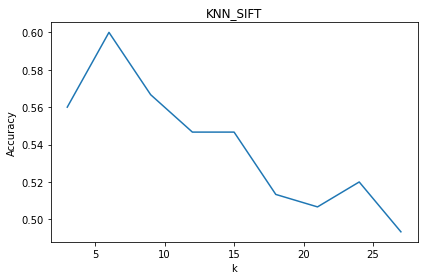

In [9]:
#change k

code_book = get_cluster(train_img, 150)
train_hist = []
for img in train_img:
    train_hist.append(get_hist(img, code_book, step_size=10))
train_hist = np.array(train_hist)
test_hist = []
for img in test_img:
    test_hist.append(get_hist(img, code_book, step_size=10))
test_hist = np.array(test_hist)

score = []
for k in range(3, 30, 3):
    pred_list = KNN(k, test_hist, train_hist, train_label)
    acc = compute_acc(pred_list, test_label)
    print(acc)
    plt.scatter(k, acc)
    score.append(acc)

plt.plot(range(3, 30, 3), score)
plt.title('KNN_SIFT')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.tight_layout()

[0.36666666666666664, 0.52, 0.4666666666666667, 0.48, 0.4866666666666667]


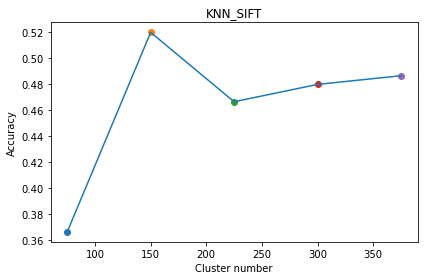

In [20]:
#change cluster number, fix k = 20
cluster_num = []
score = []
for n in range(5, 30, 5):
    cluster_num.append(class_num*n)
for i in cluster_num:
    code_book = get_cluster(train_img, i)
    train_hist = []
    for img in train_img:
        train_hist.append(get_hist(img, code_book, step_size=10))
    train_hist = np.array(train_hist)
    test_hist = []
    for img in test_img:
        test_hist.append(get_hist(img, code_book, step_size=10))
    test_hist = np.array(test_hist)
    
    pred_list = KNN(20, test_hist, train_hist, train_label)
    acc = compute_acc(pred_list, test_label)
    print(acc)
    score.append(acc)
    plt.scatter(i, acc)

plt.plot(cluster_num, score)
plt.title('KNN_SIFT')
plt.xlabel('Cluster number')
plt.ylabel('Accuracy')
plt.tight_layout()


0.5733333333333334
0.5133333333333333
0.4266666666666667
0.44666666666666666
0.3933333333333333


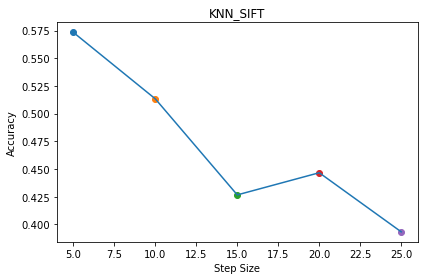

In [10]:
#change step size
step_size = []
score = []

for s in range(5, 30, 5):
    code_book = get_cluster(train_img, 150, s)
    train_hist = []
    for img in train_img:
        train_hist.append(get_hist(img, code_book, s))
    train_hist = np.array(train_hist)
    test_hist = []
    for img in test_img:
        test_hist.append(get_hist(img, code_book, s))
    test_hist = np.array(test_hist)
    
    pred_list = KNN(6, test_hist, train_hist, train_label)
    acc = compute_acc(pred_list, test_label)
    print(acc)
    score.append(acc)
    plt.scatter(s, acc)

plt.plot(range(5, 30, 5), score)
plt.title('KNN_SIFT')
plt.xlabel('Step Size')
plt.ylabel('Accuracy')
plt.tight_layout()
